# Hyperparameter Optimization for Tree Ensemble with Uncertainty Quantification (Scikit-Learn)

In this tutorial, we will see how to use Hyperparameter optimization to generate ensemble of models that can be used for uncertainty quantification.

In [1]:
import matplotlib.pyplot as plt

WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Data

For the data, we use the ``make_moons`` functionality from Scikit-Learn to have a binary-classification problem.

In addition, we randomly flip 10% of the labels to generate artificial noise (later corresponding to aleatoric uncertainty).

In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


# Dataset
def flip_binary_labels(y, ratio, random_state=None):
    """Increase the variance of P(Y|X) by ``ratio``"""
    y_flipped = np.zeros(np.shape(y))
    y_flipped[:] = y[:]
    rs = np.random.RandomState(random_state)
    idx = np.arange(len(y_flipped))
    idx = rs.choice(idx, size=int(ratio * len(y_flipped)), replace=False)
    y_flipped[idx] = 1 - y_flipped[idx]
    return y_flipped


def load_data_train_test(random_state=42):
    noise = 0.1
    n = 1_000
    ratio_flipped = 0.1  # 10% of the labels are flipped

    rng = np.random.RandomState(random_state)

    # Moons
    make_dataset = lambda n, seed: make_moons(
        n_samples=n,
        noise=noise,
        shuffle=True,
        random_state=seed,
    )

    X, y = make_dataset(n, rng.randint(2**31))
    center = np.mean(X, axis=0)
    X = X - center

    y = flip_binary_labels(y, ratio=ratio_flipped, random_state=rng.randint(2**31))
    y = y.astype(np.int64)

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.33, random_state=rng.randint(2**31), stratify=y
    )

    return (train_X, train_y), (test_X, test_y)


def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state, stratify=y
    )

    if verbose:
        print(f"train_X shape: {np.shape(train_X)}")
        print(f"train_y shape: {np.shape(train_y)}")
        print(f"valid_X shape: {np.shape(valid_X)}")
        print(f"valid_y shape: {np.shape(valid_y)}")
    return (train_X, train_y), (valid_X, valid_y)

train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)


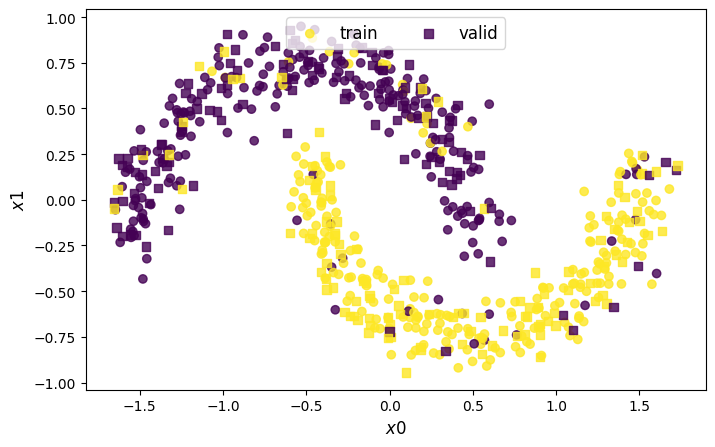

In [3]:
(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx, ty) = load_data_train_test()

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

plt.scatter(
    x[:, 0].reshape(-1), x[:, 1].reshape(-1), c=y, label="train", alpha=0.8
)
plt.scatter(
    vx[:, 0].reshape(-1),
    vx[:, 1].reshape(-1),
    c=vy,
    marker="s",
    label="valid",
    alpha=0.8,
)

plt.ylabel("$x1$", fontsize=12)
plt.xlabel("$x0$", fontsize=12)

plt.legend(loc="upper center", ncol=3, fontsize=12)

plt.show()


## Training and Scoring of Decision Tree

The class of model we use in this tutorial is Decision Tree.

In this part, we will see how to train and evaluate such models.

In [4]:
def plot_decision_boundary_decision_tree(dataset, labels, model, steps=1000, color_map="viridis"):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels_predicted = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels_predicted[:, 1].reshape(xx.shape)

    ax = plt.gca()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    ax.scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        # cmap=color_map,
        lw=0,
    )
    plt.show()

In [5]:
import pathlib
import pickle
import os

from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")


def run(job, model_checkpoint_dir=".", verbose=True, show_plots=False):

    (x, y), (vx, vy) = load_data_train_valid(verbose=verbose)
    _, (tx, ty) = load_data_train_test()

    model = DecisionTreeClassifier(**job.parameters)

    if verbose:
        print(model)

    try:
        model.fit(x, y)
        vy_pred_proba = model.predict_proba(vx)
        val_cce = log_loss(vy, vy_pred_proba)
    except:
        return "F_fit"

    # Saving the model
    with open(os.path.join(model_checkpoint_dir, f"model_{job.id}.pkl"), "wb") as f:
        pickle.dump(model, f)

    if verbose:
        print(f"{job.id}: {val_cce=:.3f}")

    if show_plots:
        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
        plot_decision_boundary_decision_tree(
            tx, ty, model, steps=1000, color_map="viridis"
        )
        plt.show()

        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
        disp = CalibrationDisplay.from_predictions(ty, model.predict_proba(tx)[:, 1])
        plt.show()

    test_cce = log_loss(ty, model.predict_proba(tx))

    # The score is negated for maximization
    # The score is -Categorical Cross Entropy/LogLoss
    return {
        "objective": -val_cce,
        "metadata": {"test_cce": test_cce, "test_acc": test_acc},
    }

## Hyperparameter Optimization Search Space

We now define the hyperparameter optimization search space for decision trees.

In [6]:
from deephyper.hpo import HpProblem


def create_hpo_problem():

    problem = HpProblem()

    problem.add_hyperparameter(["gini", "entropy", "log_loss"], "criterion")
    problem.add_hyperparameter(["best", "random"], "splitter")
    problem.add_hyperparameter((10, 1000, "log-uniform"), "max_depth", default_value=1000)
    problem.add_hyperparameter((2, 20), "min_samples_split", default_value=2)
    problem.add_hyperparameter((1, 20), "min_samples_leaf", default_value=1)
    problem.add_hyperparameter((0.0, 0.5), "min_weight_fraction_leaf", default_value=0.0)

    return problem

create_hpo_problem()

Configuration space object:
  Hyperparameters:
    criterion, Type: Categorical, Choices: {gini, entropy, log_loss}, Default: gini
    max_depth, Type: UniformInteger, Range: [10, 1000], Default: 1000, on log-scale
    min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1
    min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2
    min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    splitter, Type: Categorical, Choices: {best, random}, Default: best

## The Baseline Decision Tree

Now, we evaluate the baseline Decision Tree model by test `default_value` hyperparameters.

In [7]:
from deephyper.evaluator import RunningJob


def evaluate_decision_tree():

    model_checkpoint_dir = "models_sklearn_test"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()
    print(problem)

    default_parameters = problem.default_configuration
    print(f"{default_parameters=}")
    
    output = run(
        RunningJob(id="test", parameters=default_parameters),
        model_checkpoint_dir=model_checkpoint_dir,
        show_plots=True,
    )
    print(f"{output=}")

Configuration space object:
  Hyperparameters:
    criterion, Type: Categorical, Choices: {gini, entropy, log_loss}, Default: gini
    max_depth, Type: UniformInteger, Range: [10, 1000], Default: 1000, on log-scale
    min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1
    min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2
    min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    splitter, Type: Categorical, Choices: {best, random}, Default: best

default_parameters={'criterion': 'gini', 'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)
DecisionTreeClassifier(max_depth=1000)
0.0: val_cce=6.657


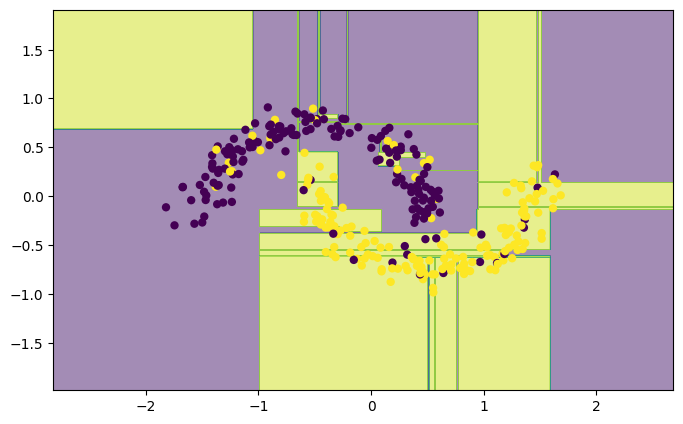

<Figure size 800x494.438 with 0 Axes>

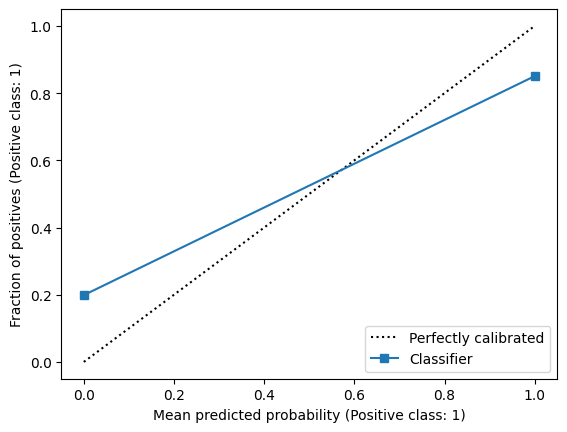

output={'objective': -6.656710761053167, 'metadata': {'test_cce': 6.3349451411175615, 'test_acc': 0.8242424242424242}}


In [8]:
evaluate_decision_tree()

The accuracy is great, but the 

## Hyperparameter Optimization

In [9]:
from deephyper.hpo import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


def run_hpo():

    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    evaluator = Evaluator.create(
        run,
        method="ray",
        method_kwargs={
            "num_cpus": 8,
            "num_cpus_per_task": 1,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [TqdmCallback()]
        },
    )
    search = CBO(
        problem,
        evaluator,
        log_dir=hpo_dir,
        initial_points=[problem.default_configuration],
        kappa=5.0,
        scheduler={"type": "periodic-exp-decay", "period": 50, "kappa_final": 0.0001},
        objective_scaler="identity",
    )

    results = search.search(max_evals=1_000)

    return search, results

In [ ]:
search, results = run_hpo()

2025-01-15 16:57:59,643	INFO worker.py:1819 -- Started a local Ray instance.
/Users/romainegele/Documents/Argonne/deephyper/src/deephyper/evaluator/_evaluator.py:148: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn("Applying nest-asyncio patch for IPython Shell!", category=UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
results

,p:criterion,p:max_depth,p:min_samples_leaf,p:min_samples_split,p:min_weight_fraction_leaf,p:splitter,objective,job_id,job_status,m:timestamp_submit,m:test_cce,m:test_acc,m:timestamp_gather
0,gini,1000,1,2,0.000000,best,-6.656711,0,DONE,1.241477,6.771838,0.812121,2.847609
1,gini,133,3,20,0.148788,best,-0.493682,6,DONE,1.250176,0.531659,0.760606,2.933041
2,entropy,137,20,14,0.264010,random,-0.693107,4,DONE,1.247422,0.693133,0.503030,2.939021
3,log_loss,41,3,8,0.447290,random,-0.693107,2,DONE,1.244864,0.693133,0.503030,2.943179
4,entropy,179,19,4,0.400292,best,-0.511322,1,DONE,1.243287,0.548213,0.760606,2.948567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,log_loss,51,17,7,0.263354,best,-0.471438,1003,DONE,247.207882,0.522736,0.766667,247.465414
1002,log_loss,48,14,4,0.263864,best,-0.471438,1004,DONE,247.209184,0.522736,0.766667,247.469688
1003,log_loss,64,16,6,0.256651,best,-0.471438,1005,DONE,247.210990,0.522736,0.766667,247.474368
1004,log_loss,54,16,6,0.261269,best,-0.471438,1002,DONE,247.206576,0.522736,0.766667,247.478765


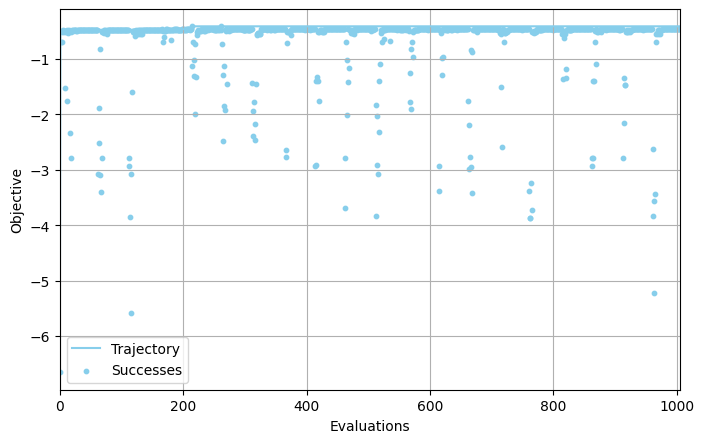

In [12]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_search_trajectory_single_objective_hpo(results)
plt.show()

## Explainability of hyperparameters

To explain the impact of our hyperparameter, we start by loading the surrogate model from the Bayesian optimization and we re-fit it on our target of interest (here the test accuracy).

The we look at the MSE of our surrogate model to evaluate if it is underfitting.

Finally we print the hyperparameter importance (based on permutation importance algorithm of the surrogate model).

In [ ]:
surrogate_model = search.get_surrogate_model()
hyperparameter_names = surrogate_model.hyperparameter_names

X = results[[f"p:{n}" for n in hyperparameter_names]].values
y = results["m:test_acc"].values
surrogate_model.fit(X, y)

topk = results.nlargest(columns=["m:test_acc"], n=3).index.values

mse = surrogate_model.evaluate(X, y)

print(f"MSE of the Surrogate Model: {mse:.3f}")

print(f"\nHyperparameter importance:")
hp_imp = surrogate_model.hyperparameter_importance(X, y, n_repeats=20)
important_hyperparameters = []
for hp_name, val in hp_imp.items():
    prefix = ""
    if val['mean'] - 2 * val['std'] > 0:
        prefix = " +++ "
        important_hyperparameters.append(hp_name)
    else:
        prefix = " --- "
    print(f"{prefix}{hp_name}: {val['mean']:.3f} ± {val['std']:.3f}")



MSE of the Surrogate Model: 0.000

Hyperparameter importance:
 +++ min_weight_fraction_leaf: 2.852 ± 0.124
 +++ splitter: 2.017 ± 0.087
 +++ criterion: 0.180 ± 0.022
 +++ min_samples_split: 0.123 ± 0.024
 +++ max_depth: 0.116 ± 0.016
 +++ min_samples_leaf: 0.089 ± 0.011


Now that we have a global understanding of hyperparameter sensitivity we can look at the top configurations.

For this we use the `shapiq` package:

```bash
pip install shapiq
```

/Users/romainegele/miniforge3/envs/dh-3.12-240724/lib/python3.12/site-packages/shapiq/explainer/tabular.py:231: UserWarning: `index='SV'` but `max_order != 1`, setting `max_order = 1`. Using the KernelSHAP approximator.
  warnings.warn(


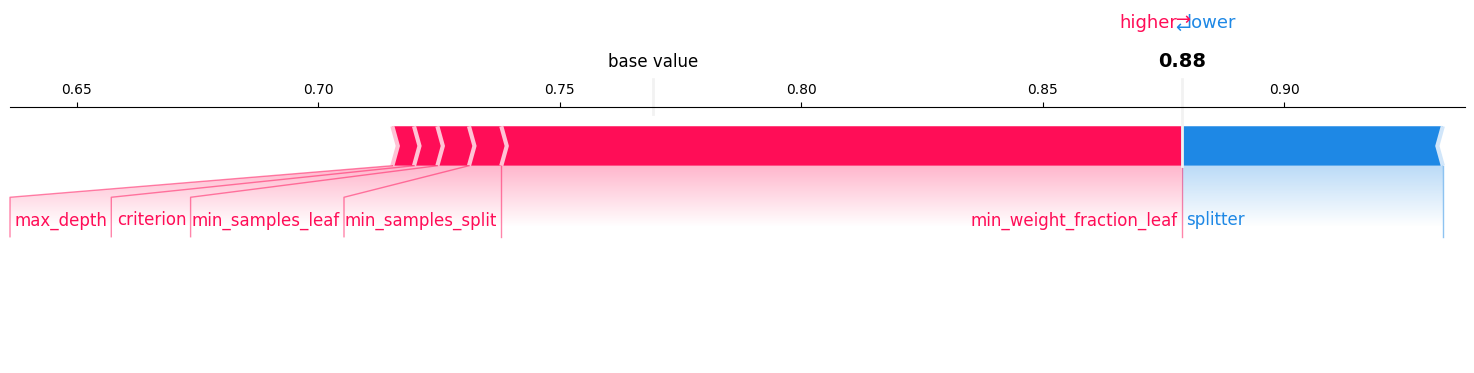

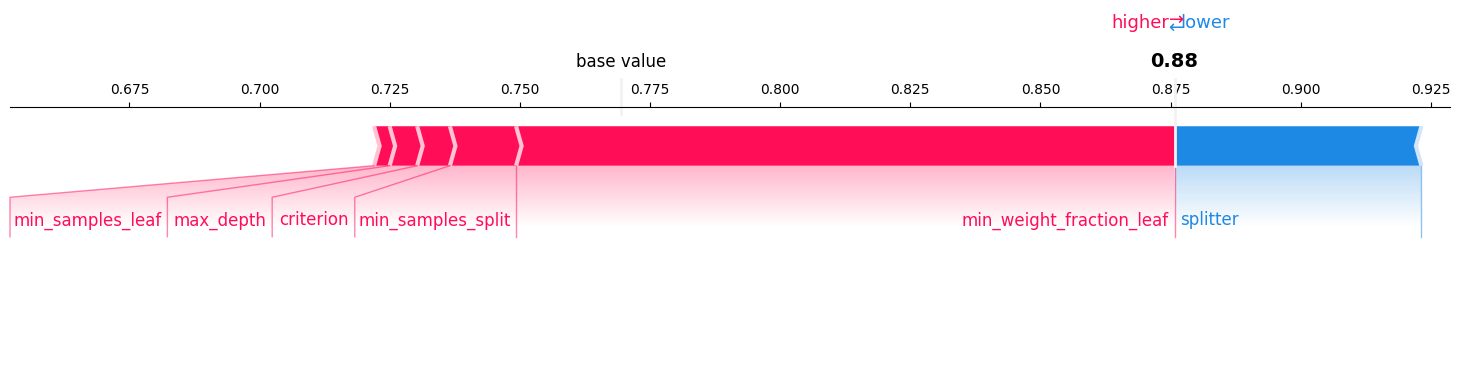

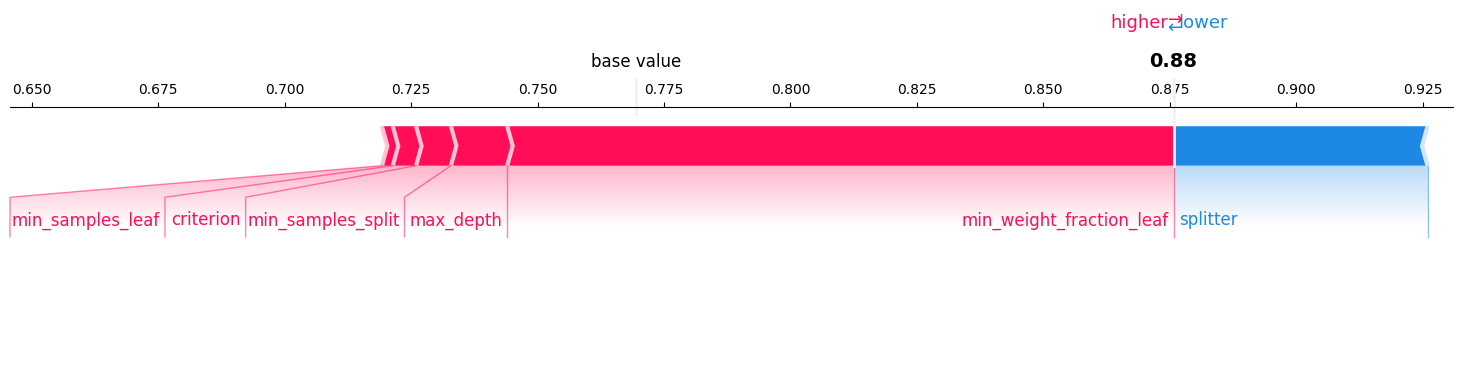

In [35]:
import shapiq

X_sample = surrogate_model.space.rvs(n_samples=len(X))
X_sample = np.asarray(X_sample)
for i, hp_name in enumerate(hyperparameter_names):
    if hp_name not in important_hyperparameters:
        X[:,i] = X_sample[:,i]

explainer = shapiq.Explainer(
    model=surrogate_model,
    data=X,
    index="SV",  # Shapley values
)
for i in topk:
    shapley_values = explainer.explain(X[i])
    shapley_values.plot_force(feature_names=hyperparameter_names, abbreviate=False)

## The Best Decision Tree

In [37]:
from deephyper.analysis.hpo import parameters_from_row

topk_rows = results.nlargest(5, "m:test_acc").reset_index(drop=True)

for i, row in topk_rows.iterrows():
    parameters = parameters_from_row(row)
    value = row["m:test_acc"]
    print(f"Top-{i+1} -> {value=:.3f}: {parameters}")
    print()

Top-1 -> value=0.879: {'criterion': 'log_loss', 'max_depth': 72, 'min_samples_leaf': 5, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0053944466453279, 'splitter': 'random'}

Top-2 -> value=0.876: {'criterion': 'entropy', 'max_depth': 615, 'min_samples_leaf': 1, 'min_samples_split': 17, 'min_weight_fraction_leaf': 0.0012155396984784, 'splitter': 'random'}

Top-3 -> value=0.876: {'criterion': 'log_loss', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0126906516085011, 'splitter': 'random'}

Top-4 -> value=0.873: {'criterion': 'gini', 'max_depth': 61, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0142396981060403, 'splitter': 'random'}

Top-5 -> value=0.873: {'criterion': 'log_loss', 'max_depth': 671, 'min_samples_leaf': 16, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0096639852789505, 'splitter': 'random'}



In [38]:
best_job = topk_rows.iloc[0]

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

with open(os.path.join(model_checkpoint_dir, f"model_0.{best_job.job_id}.pkl"), "rb") as f:
    best_model = pickle.load(f)

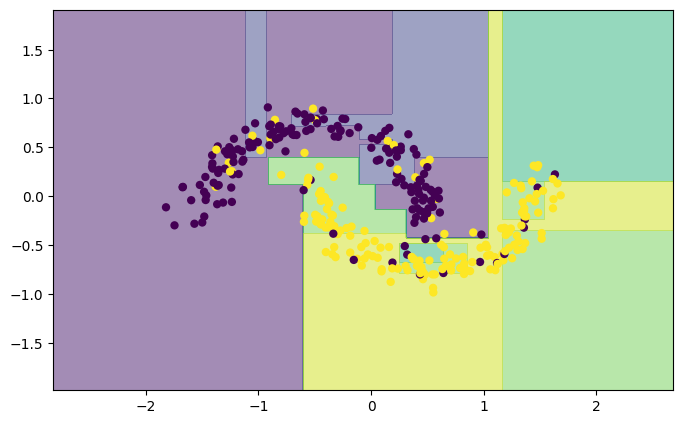

In [39]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

plot_decision_boundary_decision_tree(
    tx, ty, best_model, steps=1000, color_map="viridis"
)